<a href="https://colab.research.google.com/github/Saousonoid/Saousonoid/blob/main/ExtraSensory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip,os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.linear_model import SGDClassifier,LogisticRegression
from google.colab import drive,files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/ExtraSensory.per_uuid_features_labels/'
csv_files = os.listdir(path)
training_dataset = pd.DataFrame()  # Initialize an empty DataFrame

for files in csv_files[0:42]:
    df = pd.read_csv(os.path.join(path, files), compression='gzip')
    training_dataset = pd.concat([training_dataset, df], axis=0, ignore_index=True)

In [5]:
test_csv = pd.DataFrame()
for files in csv_files[43:61]:
  tf=pd.read_csv(os.path.join(path,files),compression='gzip')
  test_csv=pd.concat([test_csv, tf], axis=0, ignore_index=True)

In [6]:
def create_model_sets(dataset, target_label):
    dataset = dataset.dropna(subset=[target_label])
    labels = dataset.filter(like="label").iloc[:, :-1]
    label_headers = labels.columns
    features = dataset.iloc[:, 1:-len(label_headers)]
    features_headers = features.columns
    time = dataset['timestamp'].iloc[0:]
    target_label_series = labels[target_label]
    tlabel_index = dataset.columns.get_loc(target_label)
    return features, features_headers, target_label_series, tlabel_index,time

In [44]:
def normalize_features(features):
  stat_values=features.describe()
  feature_mean=stat_values.loc['mean']
  imp_features=features.fillna(feature_mean)
  scaler=MinMaxScaler()
  features_scaled=scaler.fit_transform(imp_features)
  return features_scaled

In [52]:
def select_features(features,selected_f):
  filtered_df=pd.DataFrame()
  for list in selected_f:
    selected_features = features.filter(like=list, axis=1)
    filtered_df = pd.concat([filtered_df, selected_features], axis=1)
  return filtered_df.columns,filtered_df


In [155]:
train_features, train_feature_headers, train_label, train_label_index ,train_time= create_model_sets(training_dataset, 'label:SITTING')
f_feature_names,f_features=select_features(train_features,['location','discrete','lf_measurements:screen_brightness'])
X=normalize_features(f_features)
X_names=f_feature_names
Y=train_label
Y_names=train_label_index
T=train_time
print(len(f_feature_names))



KeyboardInterrupt: ignored

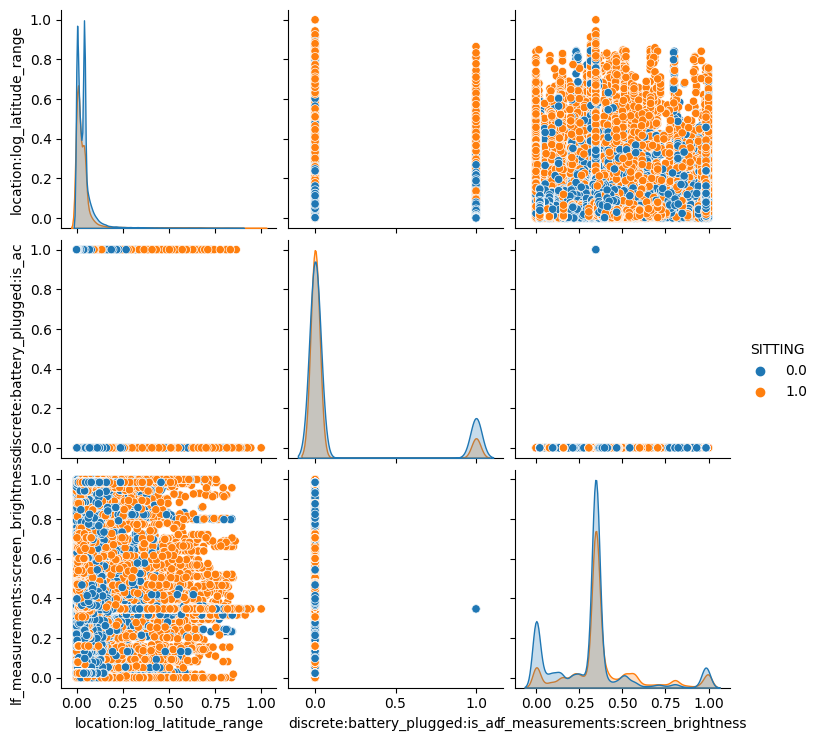

In [100]:
plotted_features ={
    X_names[1]:X[:,1],
    X_names[21]:X[:,21],
    X_names[51]:X[:,51],
    "SITTING":Y}
plotted_features=pd.DataFrame(plotted_features)
sns.pairplot(plotted_features,hue="SITTING")


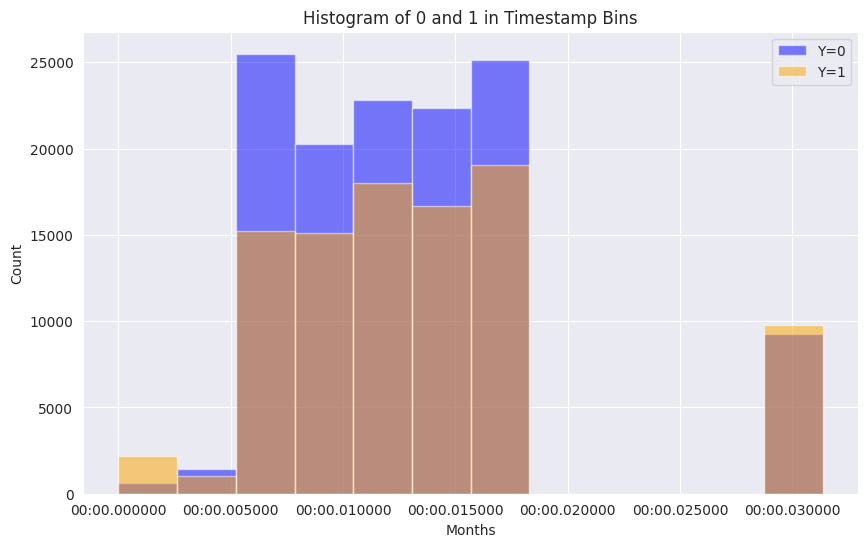

In [145]:
# plt.scatter((T-T.min())/(86400*30),Y,c=Y)
month_sits = {
    "Month": (T - T.min()),
    "SITTING": Y
}

df = pd.DataFrame(month_sits)
df=df.sort_values('Month')
df['Month'] = pd.to_datetime(df['Month'])
df['bin'] = pd.cut(df['Month'], bins=12)

# Separate data into 0 and 1
df_0 = df[df['SITTING'] == 0]
df_1 = df[df['SITTING'] == 1]

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(df_0['Month'], bins=12, alpha=0.5, label='Y=0', color='blue')
plt.hist(df_1['Month'], bins=12, alpha=0.5, label='Y=1', color='orange')

plt.xlabel('Months')
plt.ylabel('Count')
plt.title('Histogram of 0 and 1 in Timestamp Bins')
plt.legend()
plt.show()

In [149]:
def plot_decision_boundary(predict, X, y):
    x1 = np.linspace(X[:,0].min(), X[:, 0].max(), 200)
    x2 = np.linspace(X[:,1].min(), X[:, 1].max(), 200)
    X1, X2 = np.meshgrid(x1, x2)
    pts = np.c_[X1.ravel(), X2.ravel()]
    f = predict(pts).reshape(X1.shape)
    figure(figsize=(7,7))
    scatter(X[:,0], X[:,1], c=y, cmap=cm.Accent, s=50)
    contour(X1, X2, f, 1, levels=[0.5, 0.51])
    xlabel('$x_1$', fontsize=16)
    ylabel('$x_2$', fontsize=16)
    title('Logistic regression decision boundary')


In [219]:
model = SGDClassifier(loss='log_loss', max_iter=5000, random_state=10)
# Train the model on your data
model.fit(X, Y)
# Access coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients (weights):", coefficients)
print("Intercept (bias):", intercept)

Coefficients (weights): [[-0.71749716 -1.83787346 -1.56197191  0.97566356  0.86179541  2.9609617
   5.72483663  1.85802775 -0.73005678  2.08859544  0.39989453  0.25781229
   0.36260015  0.19113347  0.00798448  0.25619153  0.05834278  0.05900665
   0.10667513 -0.22397971  0.23649342 -0.23411302  0.33862212  0.
   0.07368638  0.          0.55359016 -0.0327034  -0.1805822   0.41115911
  -0.72137024  0.14810204  0.20525241 -0.13957403  0.1125171  -0.13951921
   0.12649122  0.20558221 -0.01435873 -0.04850863  0.1973309   0.
   0.02937322 -1.21944332 -0.53890082  0.32004598  0.87991964  0.6232906
   0.9989356   0.45430223  0.55335644  0.30461845]]
Intercept (bias): [-2.31600832]


In [207]:
test_features, test_feature_headers, test_label, test_label_index ,test_time= create_model_sets(test_csv, 'label:SITTING')
f_feature_names,f_features=select_features(test_features,['location','discrete','lf_measurements:screen_brightness'])
X_test=normalize_features(f_features)
X_test_names=f_feature_names
Y_test=test_label
Y_test_names=test_label_index
T_test=test_time


In [220]:
print(len(f_feature_names))
predict=model.predict(X_test)
print((predict))
accuracy =accuracy_score(Y_test,predict)
precision =precision_score(Y_test,predict)
recall =recall_score(Y_test,predict)
f1 =f1_score(Y_test,predict)
print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

52
[1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.7326446017473376
Precision: 0.6611124624989865
Recall: 0.8848553909599002
F1: 0.7567931314537649


In [205]:
model2 = LogisticRegression(max_iter=1000,C=0.3)
model2.fit(X,Y)
predict2=model2.predict(X_test)
accuracyLR =accuracy_score(Y_test,predict2)
precisionLR =precision_score(Y_test,predict2)
recallLR =recall_score(Y_test,predict2)
f1LR =f1_score(Y_test,predict2)
print("Accuracy: "+str(accuracyLR))
print("Precision: "+str(precision))
print("Recall: "+str(recallLR))
print("F1: "+str(f1LR))

Accuracy: 0.7256297430010841
Precision: 0.6611124624989865
Recall: 0.8470345650876336
F1: 0.7437583380979607


In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def predict(X, w, b):
    return sigmoid(np.dot(X, w) + b)

def cross_entropy(y, p):
    return -(y * np.log(p) + (1 - y) * np.log(1.0 - p)).mean()

def loss(X, y, w, b):
    p = predict(X, w, b)
    return cross_entropy(y, p)

def d_loss(X, y, w, b):
    p = predict(X, w, b)
    dw = ((p - y)[:, np.newaxis] * X).mean(axis=0)
    db = (p - y).mean()
    return dw, db

In [ ]:
def gradient_descent_optimize(X, y, loss, d_loss, lr=1e-3, epochs=2000, verbose=True):

    # initialize weights and bias
    w = np.zeros(X.shape[1])
    b = 1

    # set the initial learning rate
    alpha = lr

    # save learning curves to losses
    losses = []

    for i in range(epochs):

        # compute loss
        L = loss(X, y, w, b)

        # print loss
        if i % 10 == 0 and verbose:
            print('Epoch {} Loss: {}'.format(i, L))

        # compute gradient of loss wrt parameters
        dw, db = d_loss(X, y, w, b)

        # update parameters
        w = w - alpha * dw
        b = b - alpha * db

        # save loss
        losses.append(L)

    return w, b, losses